In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [2]:
engine = create_engine("sqlite:///hawaii.sqlite")

In [3]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [4]:
Base.classes.keys()

['measurement', 'station']

In [5]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [6]:
# Create our session (link) from Python to the DB
session = Session(engine)

C:\Users\Liam 2\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 'date' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  if sys.path[0] == '':


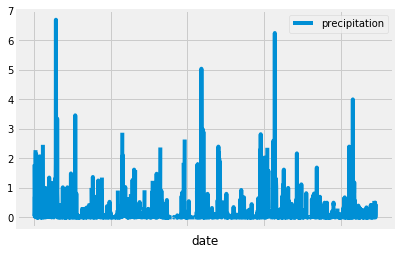

In [7]:
# Calculate the date one year from the last date in data set.
lastYear = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
answers = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= lastYear).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
dfRain = pd.DataFrame(answers, columns=['date', 'precipitation'])
dfRain.set_index(dfRain['date'], inplace=True)

# Sort the dataframe by date
dfRain = dfRain.sort_values("date")

# Use Pandas Plotting with Matplotlib to plot the data
dfRain.plot(x_compat=True)

In [8]:
# Use Pandas to calcualte the summary statistics for the precipitation data
dfRain.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [9]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [10]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [11]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').all()

[(54.0, 85.0, 71.66378066378067)]

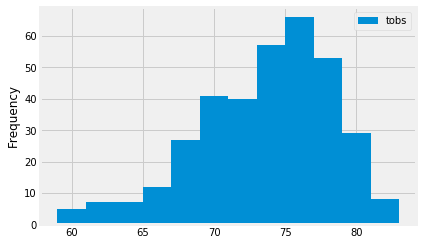

In [12]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from pandas.plotting import table
topStation = session.query(Measurement.tobs).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= lastYear).all()
dfTop = pd.DataFrame(topStation, columns=['tobs'])
dfTop.plot.hist(bins=12)

In [13]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(startDate, endDate):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        startDate (string): Date as %Y-%m-%d
        endDate (string): Date as %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= startDate).filter(Measurement.date <= endDate).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [14]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
tripStart = dt.date(2018, 5, 22) - dt.timedelta(days=365)
tripEnd = dt.date(2018, 5, 30) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(tripStart.strftime("%Y-%m-%d"), tripEnd.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

69.0 75.28846153846153 87.0


C:\Users\Liam 2\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


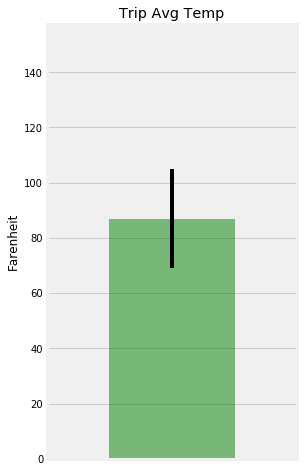

In [15]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='green', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Farenheit")
ax.margins(.5, .5)
fig.show()

In [16]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
startDate = '2012-01-01'
endDate = '2012-01-07'

stat = [func.sum(Measurement.prcp), Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation]

answers = session.query(*stat).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= startDate).\
    filter(Measurement.date <= endDate).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(answers)



[(0.31, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4), (0.25, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9), (0.1, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6), (0.060000000000000005, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6), (0.0, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9), (0.0, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0), (0.0, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9), (0.0, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0), (0.0, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)]
